# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [4]:
%pip install labelme tensorflow  opencv-python matplotlib albumentations

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.


### 1.2 Collect Images Using OpenCV

In [5]:
import os
import time
import uuid
import cv2

In [24]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [25]:
for i in range(5):  # Check for the first 5 camera indices
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera index {i} is working")
        cap.release()
    else:
        print(f"Camera index {i} is not available")

Camera index 0 is working
Camera index 1 is not available
Camera index 2 is not available
Camera index 3 is not available
Camera index 4 is not available


In [26]:

cap = cv2.VideoCapture(0)  

if not cap.isOpened():
    print("Error: Could not open video stream or file")
else:
    for imgnum in range(number_images):
        print('Collecting image {}'.format(imgnum))
        ret, frame = cap.read()

        if not ret:
            print("Error: Could not read frame from camera")
            break
        
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)  # Save the image
        time.sleep(0.5)  # Adjust this delay based on your requirement

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


### 1.3 Annotate Images with LabelMe

In [27]:
!labelme

2025-01-02 17:19:22,098 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\DELL\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [28]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.3 Load Image into TF Data Pipeline

In [29]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [30]:
images.as_numpy_iterator().next()

b'data\\images\\6c268772-c8ff-11ef-aacb-c506766d06b5.jpg'

In [31]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [32]:
images = images.map(load_image)

In [33]:
images.as_numpy_iterator().next()

array([[[135, 137, 132],
        [133, 135, 130],
        [148, 150, 147],
        ...,
        [138, 144, 142],
        [142, 146, 147],
        [141, 145, 146]],

       [[123, 125, 120],
        [122, 124, 119],
        [139, 141, 136],
        ...,
        [139, 145, 143],
        [142, 146, 145],
        [145, 149, 148]],

       [[125, 128, 121],
        [123, 126, 119],
        [150, 152, 147],
        ...,
        [142, 147, 143],
        [140, 145, 141],
        [143, 148, 144]],

       ...,

       [[ 59,  58,  63],
        [ 65,  65,  67],
        [ 68,  68,  70],
        ...,
        [137, 137, 139],
        [136, 134, 139],
        [131, 129, 134]],

       [[ 57,  56,  62],
        [ 64,  63,  69],
        [ 67,  66,  72],
        ...,
        [127, 127, 129],
        [130, 127, 134],
        [127, 124, 131]],

       [[ 60,  59,  67],
        [ 65,  64,  72],
        [ 66,  65,  71],
        ...,
        [126, 125, 130],
        [134, 131, 138],
        [133, 130, 139]]

In [34]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [35]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_images = image_generator.next()

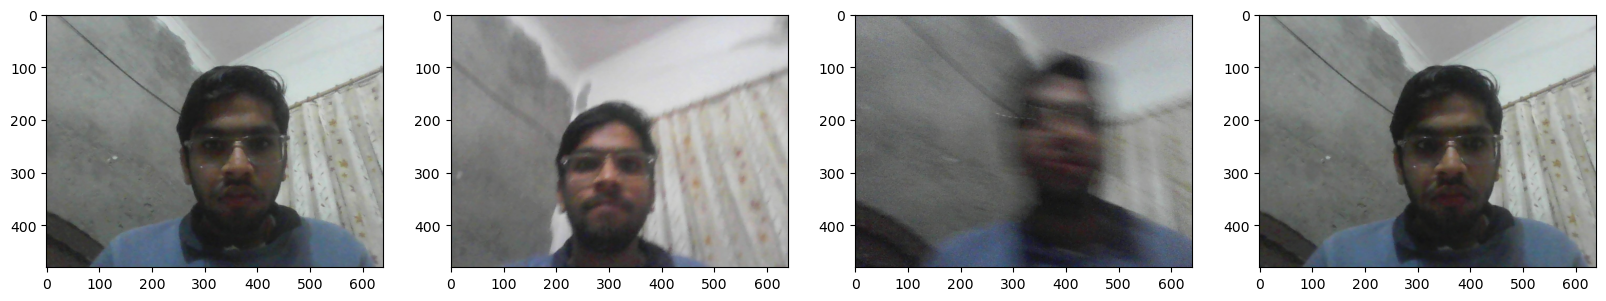

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 SPLIT DATA INTO TRAIN TEST AND VAL

In [39]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to the folders
images_folder = r'C:\Users\DELL\Desktop\Face detector\Data\images'
train_folder = r'C:\Users\DELL\Desktop\Face detector\Data\train\images'
val_folder = r'C:\Users\DELL\Desktop\Face detector\Data\val\images'
test_folder = r'C:\Users\DELL\Desktop\Face detector\Data\test\images'

# Get a list of all images
images = os.listdir(images_folder)

# Split sizes
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# First split: train and remaining (val + test)
train_images, temp_images = train_test_split(
    images, train_size=train_ratio, random_state=42
)

# Second split: val and test
val_images, test_images = train_test_split(
    temp_images, test_size=test_ratio/(test_ratio + val_ratio), random_state=42
)

# Function to copy images to their respective directories
def copy_files(file_list, src_folder, dest_folder):
    for file in file_list:
        shutil.copy(os.path.join(src_folder, file), os.path.join(dest_folder, file))

# Copy the files
copy_files(train_images, images_folder, train_folder)
copy_files(val_images, images_folder, val_folder)
copy_files(test_images, images_folder, test_folder)

print("Images have been split into train, validation, and test sets.")


Images have been split into train, validation, and test sets.


### 3.2 Move the Matching Labels

In [40]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [41]:
import albumentations as alb

c:\Users\DELL\anaconda3\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [42]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [43]:
img = cv2.imread(os.path.join('data','train', 'images','d1f781b3-7c8b-11ef-a405-ca39ccf5f82e.jpg'))

In [44]:
img.shape


(480, 640, 3)

In [45]:
with open(os.path.join('data', 'train', 'labels', 'd1f781b3-7c8b-11ef-a405-ca39ccf5f82e.json'), 'r') as f:
    label = json.load(f)

In [46]:
label['shapes'][0]['points']

[[307.5, 173.88888888888889], [581.9444444444443, 464.44444444444446]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [47]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [48]:
coords

[307.5, 173.88888888888889, 581.9444444444443, 464.44444444444446]

In [49]:
coords = list(np.divide(coords, [640,480,640,480]))

In [50]:
coords

[0.48046875, 0.3622685185185185, 0.9092881944444443, 0.9675925925925927]

### 4.4 Apply Augmentations and View Results

In [51]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [52]:
augmented['bboxes'][0][2:]

[1.0, 0.6291358142428928]

In [53]:
augmented['bboxes']

[[0.5877777777777777, 0.0, 1.0, 0.6291358142428928]]

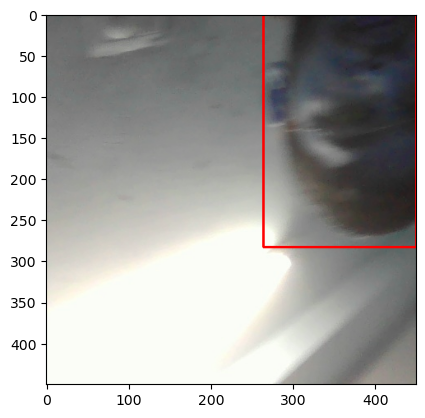

In [54]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [55]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type


c:\Users\DELL\anaconda3\Lib\site-packages\albumentations\core\bbox_utils.py:469: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


y_max is less than or equal to y_min for bbox [0.2000868  0.6388889  0.65581596 0.00462963 0.        ].
y_max is less than or equal to y_min for bbox [0.2860243  0.74189812 0.79817706 0.01041667 0.        ].
y_max is less than or equal to y_min for bbox [0.15668403 0.55208331 0.72439235 0.01041667 0.        ].
x_max is less than or equal to x_min for bbox [0.24262153 0.01041667 0.00477431 0.85416669 0.        ].
y_max is less than or equal to y_min for bbox [0.76605904 0.86689812 0.99175346 0.00115741 0.        ].
y_max is less than or equal to y_min for bbox [0.56987846 0.6423611  0.99348956 0.01388889 0.        ].
y_max is less than or equal to y_min for bbox [0.53776044 0.77430558 0.99348956 0.00925926 0.        ].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [56]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [57]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [58]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [59]:
train_images.as_numpy_iterator().next()

array([[[0.1666054 , 0.23039216, 0.28474265],
        [0.17843138, 0.23039216, 0.27561274],
        [0.18627451, 0.23333333, 0.29313725],
        ...,
        [0.3514706 , 0.36372548, 0.35049018],
        [0.34313726, 0.3658701 , 0.35796568],
        [0.34417892, 0.36464462, 0.35833332]],

       [[0.20637254, 0.21323529, 0.2901961 ],
        [0.1911152 , 0.23100491, 0.27941176],
        [0.17683823, 0.2401348 , 0.29803923],
        ...,
        [0.3529412 , 0.37254903, 0.35686275],
        [0.34515932, 0.36868873, 0.35900736],
        [0.32830882, 0.36360294, 0.3514706 ]],

       [[0.2069853 , 0.22824755, 0.30569854],
        [0.17340687, 0.23921569, 0.3019608 ],
        [0.14178921, 0.24356617, 0.3093137 ],
        ...,
        [0.34944853, 0.37297794, 0.35729167],
        [0.35153186, 0.37506127, 0.359375  ],
        [0.34258577, 0.3778799 , 0.36317402]],

       ...,

       [[0.37990198, 0.40281862, 0.39528185],
        [0.42205882, 0.45833334, 0.44509804],
        [0.45729166, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [60]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [61]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [63]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [64]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0315, 0.1608, 0.5845, 0.7856], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [65]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4560, 4560, 840, 840, 1380, 1380)

### 7.2 Create Final Datasets (Images/Labels)

In [66]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

In [67]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(500)
test = test.batch(8)
test = test.prefetch(4)

In [68]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [69]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2451 , 0.     , 0.804  , 0.559  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2078 , 0.2874 , 0.714  , 0.9614 ],
        [0.303  , 0.2996 , 0.855  , 0.956  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.09076, 0.2678 , 0.686  , 0.991  ],
        [0.379  , 0.3228 , 0.9395 , 0.994  ],
        [0.1895 , 0.01062, 0.7485 , 0.597  ]], dtype=float16))

### 7.3 View Images and Annotations

In [70]:
data_samples = train.as_numpy_iterator()

In [71]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


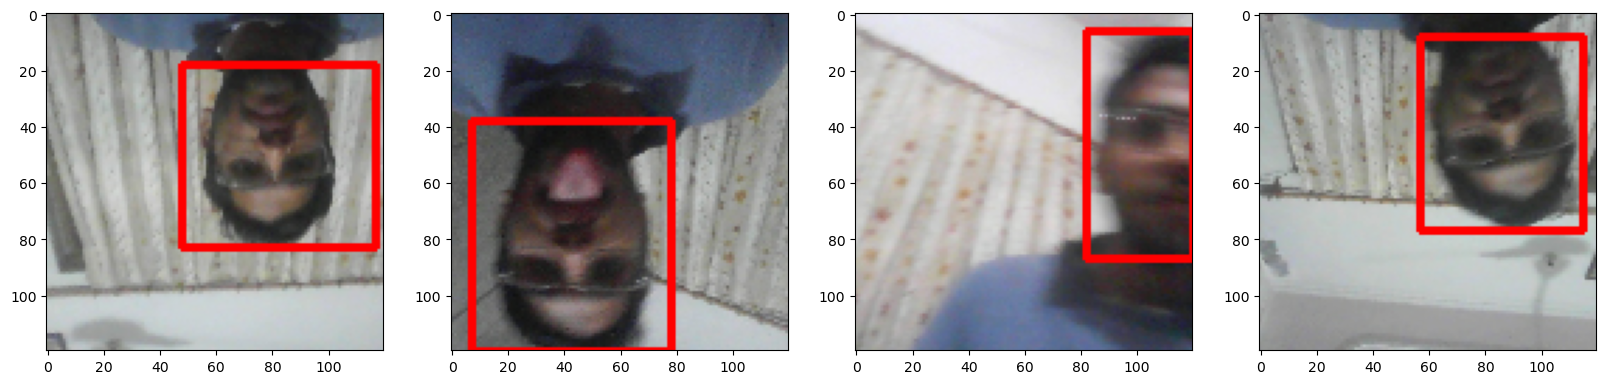

In [75]:

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4): 
    sample_image = np.copy(res[0][idx])  # Create a writable copy of the image
    sample_coords = res[1][1][idx]
    
    # Draw rectangle on the sample_image
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [77]:
vgg = VGG16(include_top=False)

In [78]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [79]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [80]:
facetracker = build_model()

In [81]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
X, y = train.as_numpy_iterator().next()

In [83]:
X.shape
y

(array([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.366 , 0.3096, 0.872 , 0.984 ],
        [0.2345, 0.2925, 0.7803, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1453, 0.    , 0.7515, 0.727 ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [84]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


In [85]:
classes, coords

(array([[0.5847628 ],
        [0.5915497 ],
        [0.55642056],
        [0.5443237 ],
        [0.6038408 ],
        [0.51846915],
        [0.5542479 ],
        [0.57264197]], dtype=float32),
 array([[0.58269554, 0.39714476, 0.50310063, 0.6372992 ],
        [0.567138  , 0.42904738, 0.54087806, 0.60928965],
        [0.552065  , 0.44166103, 0.5650505 , 0.62357473],
        [0.551008  , 0.49870247, 0.5283302 , 0.6384241 ],
        [0.6528356 , 0.40231007, 0.4328265 , 0.5544493 ],
        [0.5701454 , 0.47604755, 0.5780375 , 0.54922056],
        [0.64127135, 0.45563668, 0.4268322 , 0.5875176 ],
        [0.5533478 , 0.3868168 , 0.55273914, 0.5732469 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [86]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [87]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [88]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [89]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [90]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.615019>

In [91]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.71967626>

In [92]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.615019>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [93]:
class FaceTracker(Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        y[0].set_shape([None,1])  


        print(f"Shape of y[0]: {y[0].shape}")
        print(f"Shape of y[1]: {y[1].shape}")
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        y[0].set_shape([None,1])  

        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [94]:
model = FaceTracker(facetracker)

In [95]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [96]:
logdir='logs'

In [97]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [98]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
Shape of y[0]: (None, 1)
Shape of y[1]: <unknown>
Shape of y[0]: (None, 1)
Shape of y[1]: <unknown>
570/570 ━━━━━━━━━━━━━━━━━━━━ 1953s 3s/step - class_loss: 0.1674 - regress_loss: 0.5281 - total_loss: 0.6118 - val_class_loss: 0.0065 - val_regress_loss: 0.0511 - val_total_loss: 0.0544
Epoch 2/5
570/570 ━━━━━━━━━━━━━━━━━━━━ 1205s 2s/step - class_loss: 0.0374 - regress_loss: 0.1343 - total_loss: 0.1530 - val_class_loss: 1.6055 - val_regress_loss: 0.9417 - val_total_loss: 1.7444
Epoch 3/5
570/570 ━━━━━━━━━━━━━━━━━━━━ 1336s 2s/step - class_loss: 0.0252 - regress_loss: 0.1025 - total_loss: 0.1151 - val_class_loss: 1.0491 - val_regress_loss: 0.6937 - val_total_loss: 1.2182
Epoch 4/5
570/570 ━━━━━━━━━━━━━━━━━━━━ 1362s 2s/step - class_loss: 0.0151 - regress_loss: 0.0672 - total_loss: 0.0748 - val_class_loss: 1.6086e-04 - val_regress_loss: 0.0671 - val_total_loss: 0.0672
Epoch 5/5
570/570 ━━━━━━━━━━━━━━━━━━━━ 1312s 2s/step - class_loss: 0.0197 - regress_loss: 0.0705 - total_loss: 0.080

### 10.3 Plot Performance

In [99]:
hist.history

{'class_loss': [0.003342431504279375,
  0.11009864509105682,
  0.15994000434875488,
  0.0004771353560499847,
  0.0017459976952522993],
 'regress_loss': [0.09594397991895676,
  0.19007699191570282,
  0.5001906752586365,
  0.012331882491707802,
  0.07177738845348358],
 'total_loss': [0.09761519730091095,
  0.24512630701065063,
  0.5801606774330139,
  0.012570450082421303,
  0.07265038788318634],
 'val_class_loss': [0.006535797379910946,
  1.6054930686950684,
  1.049055814743042,
  0.00016085983952507377,
  7.649034523637965e-05],
 'val_regress_loss': [0.051102399826049805,
  0.941680371761322,
  0.6936701536178589,
  0.06707759946584702,
  0.10250955075025558],
 'val_total_loss': [0.054370298981666565,
  1.744426965713501,
  1.2181980609893799,
  0.06715802848339081,
  0.1025477945804596]}

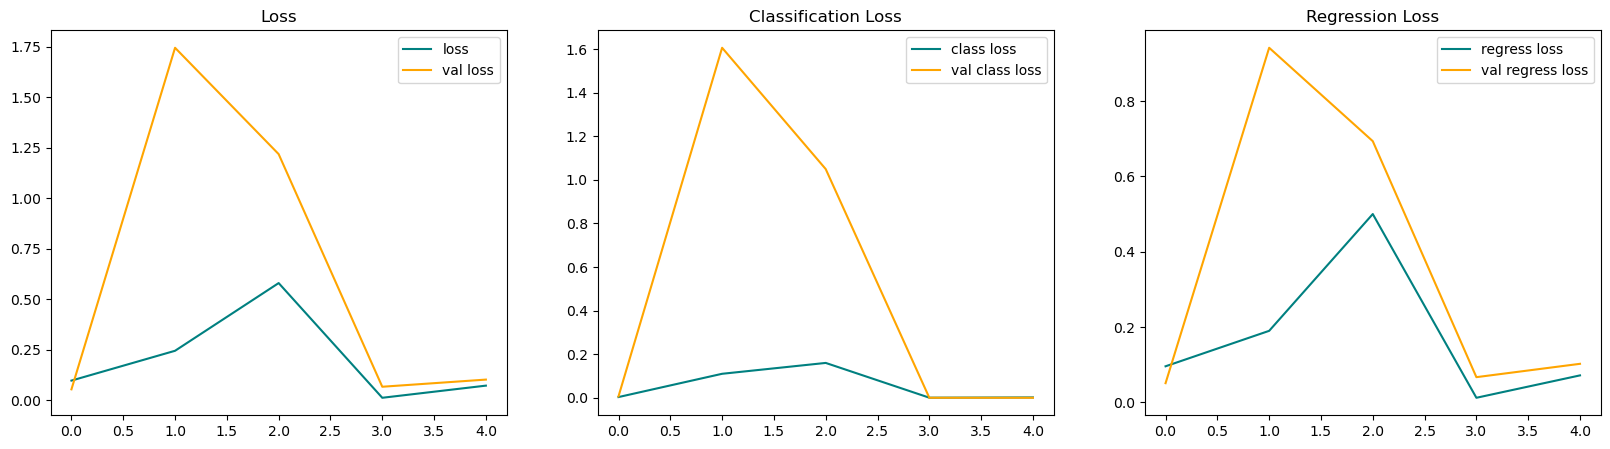

In [100]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [101]:
test_data = test.as_numpy_iterator()

In [102]:
test_sample = test_data.next()

In [103]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


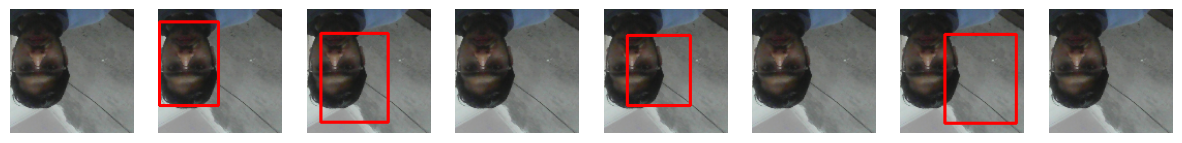

In [105]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming yhat and sample_image are already defined
# Example values for yhat and sample_image for demonstration purposes
# yhat = (probabilities, coordinates)
# sample_image is a numpy array representing the image

fig, ax = plt.subplots(1, len(yhat[0]), figsize=(15, 5))

for idx in range(len(yhat[0])):
    # Make a writable copy of the image
    sample_image_copy = sample_image.copy()

    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image_copy, 
                      tuple(np.multiply(sample_coords[:2], [sample_image.shape[1], sample_image.shape[0]]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [sample_image.shape[1], sample_image.shape[0]]).astype(int)), 
                      (255, 0, 0), 2)

    ax[idx].imshow(sample_image_copy)
    ax[idx].axis('off')

plt.show()


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [1]:
from tensorflow.keras.models import load_model

In [107]:
facetracker.save('facetracker.h5')

In [2]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [6]:
import cv2
import tensorflow as tf
import numpy as np

# Load the image
image_path = r'C:\Users\DELL\Desktop\Face detector\WIN_20250103_18_30_14_Pro.jpg'
image = cv2.imread(image_path)

# Convert image to RGB (if it's in BGR as OpenCV loads images in BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize image to match model input size, assume model takes 120x120 input size
resized_image = cv2.resize(image_rgb, (120, 120))

# Normalize the image if needed (model might expect values between 0 and 1)
resized_image = resized_image / 255.0

# Expand dimensions to match the input format (batch size, height, width, channels)
input_image = np.expand_dims(resized_image, axis=0)

# Make prediction
yhat = facetracker.predict(input_image)

# Process yhat for your needs (e.g., extracting bounding box coordinates)
print("Prediction: ", yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Prediction:  [array([[0.9956041]], dtype=float32), array([[0.21362801, 0.21270476, 0.6802118 , 0.8696959 ]], dtype=float32)]


In [10]:
import cv2


In [11]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Specify the input folder containing images
input_folder = r'C:\Users\DELL\Desktop\Face detector\real time photos'
output_folder = r'C:\Users\DELL\Desktop\Face detector\pred'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through all images in the input folder
for filename in os.listdir(input_folder):
    # Build the full image path
    image_path = os.path.join(input_folder, filename)
    image = cv2.imread(image_path)

    # Check if the file is a valid image
    if image is None:
        print(f"Skipping invalid file: {filename}")
        continue

    # Resize the image to match the model input
    resized_image = cv2.resize(image, (120, 120))
    normalized_image = resized_image / 255.0  # Normalize the image

    # Predict using the facetracker model
    yhat = facetracker.predict(np.expand_dims(normalized_image, axis=0))
    confidence = yhat[0][0][0]
    coords = yhat[1][0]

    if confidence > 0.5:
        # Scale coordinates back to the original image size
        h, w, _ = image.shape
        x1, y1, x2, y2 = np.multiply(coords, [w, h, w, h]).astype(int)

        # Draw a rectangle around the detected face
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, f"Confidence: {confidence:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Save the output image to the "pred" folder
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, image)
    print(f"Processed and saved: {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processed and saved: C:\Users\DELL\Desktop\Face detector\pred\istockphoto-507995592-612x612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Processed and saved: C:\Users\DELL\Desktop\Face detector\pred\WIN_20250103_18_30_14_Pro.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Processed and saved: C:\Users\DELL\Desktop\Face detector\pred\WIN_20250103_18_51_11_Pro.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Processed and saved: C:\Users\DELL\Desktop\Face detector\pred\WIN_20250103_18_51_14_Pro.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Processed and saved: C:\Users\DELL\Desktop\Face detector\pred\WIN_20250103_18_51_20_Pro.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Processed and saved: C:\Users\DELL\Desktop\Face detector\pred\WIN_20250103_18_51_28_Pro.jpg
